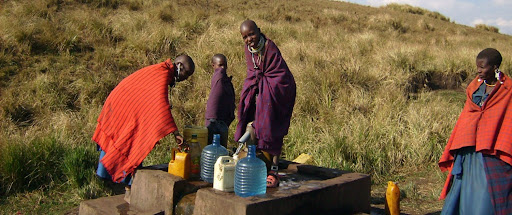

# Modeling Water Wells in Tanzania
---

**Authors**: [Kelsey Lane](https://github.com/kelsklane), [Andy Schmeck](https://github.com/andrewschmeck), and [Ted Brandon](https://github.com/theobigdog)

Date:  10/29/2021

## Overview
---
This project uses data about Tanzanian wells provided by [DrivenData](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) to model if these wells are functional or not to help a non-government agency in determining which wells they need to repair. After the data were cleaned, various iterative classification models were run in order to identify a model that has the best mix of a high percision and low complexity. We found that the amount of total static head of the well, alongside its installer, extraction type, and if it had a government permit, were all significant predictors in classifying the functionality of a well with 75% percision.

## Business Understanding
---
Summary of the business problem you are trying to solve, and the data questions that you plan to answer to solve them.

Questions to consider:

- Who are your stakeholders? What are we trying to solve?
- What are your stakeholders' pain points related to this project?
- Why are your predictions important from a business perspective? aka implications of project for real-world problem

**This is just the rubric they give us to follow for reference**

Andy will add this

##### Precision

Precision will be the metric used for this analysis.  This is because we want to be more sensitive to false positives since some of these areas are quite remote. Therefore, it is very important that we only send repair crews to the wells that are actually nonfunctional or in need of repair.

## Data Understanding and Preperation
---
The data used in this analysis is provided by Taarifa and the Tanzanian Ministry of Water and is obtained through the [DrivenData competition](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/). The dataset includes 59,400 wells where each well has 41 different features recorded alongside the target column, status_group, which indicates if the well is functional, in need of repair, or non-functional. We are able to use the features provided about each well to build a classification model to predict the status of the well, and thus help the NGO determine which wells of unknown status may or may not need repairs.

In [4]:
#Imports needed modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
from pandas.core.common import SettingWithCopyWarning

#Brings together the features and target for easier engineering
df_feat = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv')
df_targ = pd.read_csv('data/Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv')
df = pd.concat([df_feat, df_targ], axis = 1)

#Filters out copy warnings for readability
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

### Column Inclusion

The dataset has many columns that represent duplicate information just at different granularities. To help illustrate this the columns in the original dataset are listed out below.

In [9]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'id', 'status_group'],
      dtype='object')

As you can see, there is a lot of overlap, like with waterpoint_type and waterpoint_type_group or extraction_type, extraction_type_group, and extraction_type_class. These would pose multicollinearity issues, as it's the same information represented at different levels, so for all overlaping columns, the most general ones were kept in order to reduce dimentionality in the data. For insurance, each column was tested with a chi2 test first to ensure true relation, with an example shown below.

In [10]:
# Import relevant module
from scipy.stats import chi2_contingency

#Run the test and check the p-value to see if it's below .05
chi2, pval, dof, expected = chi2_contingency(pd.crosstab(df['extraction_type'], df['extraction_type_class']))
pval

0.0

Furthremore, there are other columns that are unclear. For example, num_private is a column with no description given by the DrivenData site and it's not obvious what this feature indicates. A similar idea holds for public_meeting. As a reuslt, these features are dropped. Other unnecessary columns that were dropped include id, as it is just the unique identifier for each row, recorded_by, as it is the same entry for every row, and funder, as it does not seem likely that the funder of the well had any impact on its future functionality. This left us with the following dataset.

In [24]:
#Get rid of the excess columns
df_trim = df.drop(columns = ['id', 'extraction_type', 'extraction_type_group', 'scheme_name',
                            'payment', 'quality_group', 'quantity_group', 'source_type', 'waterpoint_type_group',
                            'region_code', 'district_code', 'ward', 'subvillage', 'lga', 'num_private',
                            'recorded_by', 'funder', 'public_meeting', 'wpt_name'], axis = 1)
#Display remaining columns
df_trim.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'installer', 'longitude',
       'latitude', 'basin', 'region', 'population', 'scheme_management',
       'permit', 'construction_year', 'extraction_type_class', 'management',
       'management_group', 'payment_type', 'water_quality', 'quantity',
       'source', 'source_class', 'waterpoint_type', 'status_group'],
      dtype='object')

As it is unclear from the remaining columns what features may or may not be significant in predicting well failure, the rest of the columns are left in for the time being. These will be paired down later using a decision tree to find the most significant indicators, but the columns remaining all seem different from each other and good potential predictors. The continuous variables were checked against each other using a heatmap to see if there was any multicolinearity, of which there was none. Two important notes, despite the similar column names source and source_class, as well as management and management_group appear to represent different pieces of information, and thus are retained depsite the similar column names.

### Add in an explanation for what the reamining columns mean? At least the unintuitive ones like permit or scheme_management

### Data Cleaning

One issue in the remaining data has to do with longitude and latitude. Tanzania does not include 0$^{\circ}$ 0$^{\circ}$, but there are occurances of these coordinates in the data which seem to represent null or unrecorded values. As a result, the rows containing these points are dropped as they represent only 3\% of the data.

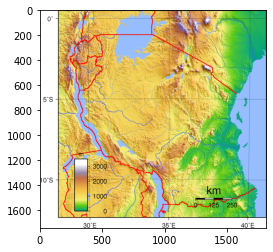

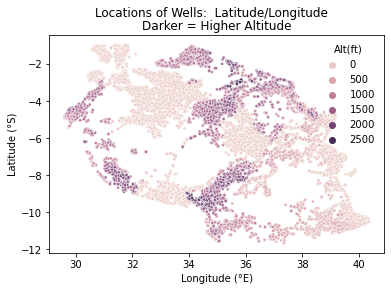

In [25]:
#Dropping bad longitude/latitude rows
df_trim = df_trim[df_trim['longitude'] != 0]

#Import image of Tanzania
image = mpimg.imread("Images/Tanzania_Topography.png")
plt.imshow(image)
plt.show()

#Display updated coordinates to check for any other anomolies
sns.scatterplot(x = df_trim['longitude'], y = df_trim['latitude'], hue = df_trim['gps_height'],
                marker='.', alpha=0.75)
plt.suptitle('Locations of Wells:  Latitude/Longitude')
plt.title('Darker = Higher Altitude')
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°S)')
plt.legend(fontsize=10, loc='upper right', frameon=False, title='Alt(ft)');

Permit is a remaining column with null values that represents if the well is or is not government approved. We elected to fill the missing values with False rather than the median or mean value of the column as we felt that unrecorded values made more sense to be False rather than True between the two. As a result these are filled ahead of time before the train-test split.
**better justification? I can't really remember why**

In [26]:
#Filling the nulls in "permit" with the mode, False
df_trim['permit'] = df_trim['permit'].fillna(value = False)

Finally, there are 18,897 0s in the construction_year column which represent null values. As this is a high proportion of the column and we didn't want to simply impute the value with another, we instead opted to bin the column into decades and replace the 0s with Unknown.

In [27]:
#Bins years into decades
def decades(year):
    #Returns unknown if value not recorded
    if year == 0:
        return 'Unknown'
    else:
        return str((year // 10) * 10)
#Applies mapping to column
df_trim['construction_year'] = df_trim['construction_year'].apply(decades)

Finally, scheme_management and installer both have null values remaining. As they also have a large number of unique entries, these columns are binned into the top five most frequent values and other, where the null values are filled with other as well. Since we didn't want to risk data leakage this process is done later on after the trian-test split to get frequencies based only on the training data.

### Feature Creation

Since the season in which the well data was recorded may affect the funcitonality of the well, as wells recorded during a rainy season may have more water depending on their source, we elected to add a season column based on the date recorded and then drop the date recorded column.

In [29]:
#Grabs the month
df_trim['month'] = pd.DatetimeIndex(df_trim['date_recorded']).month

#Makes dictionary to map month to season
season = {1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 5: 'Spring', 6: 'Summer', 7: 'Summer', 
          8: 'Summer', 9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'}

#Applies transformation and drops month and date_recorded
df_trim['season'] = df_trim['month'].map(season)
df_trim = df_trim.drop(columns = ['month', 'date_recorded'], axis = 1)

### Fixing up the Target

In the original dataset status_group is a column containing functional, non funcitonal, and functional needs repair. As we are engineering this problem to be binary, non functional and functional needs repair are collapsed into one column, as these are the wells the NGO would want to identify as they require some kind of attention. This also eliminates the issues with class imbalance present in the original distinction, leaving the classes now relatively even with 54% of the wells being functional and 46% needing some attention.

In [31]:
#Maps the columns to the binary target 0 or 1
df_trim.status_group = df_trim.status_group.map({'functional' : 0, 'non functional': 1, 'functional needs repair': 1})

### Limitations

Finally, there are some limitations in the dataset. For one, both amount_tsh and population have high 0 counts. While 0 is a valid potential entry for these columns, it has also been used to represent null values throughout the dataset. Therefore, it's not clear how many of these 0s represent actual 0s and how many represent nulls. This creates issues as these columns are also the only ones with outliers that are unaccounted for. However, due to the heavy skew that the 0s add to the data it isn't clear where to draw the cutoff for outliers, if the values would even be outliers after cleaning up the nulls. Therefore, this gums up the data and makes the results of using these columns unclear. We were also limited in our ability to use more oclumns as we didn't know what kind of data they recorded, like num_private and public_meeting. Lastly we were limited to the timeframe the data was collected which could impact our predictive abilities.

## Modeling
---
Since there isn't much class imbalance present in the data, we opted to use a DummyClassifier to create a baseline model based on the most frequent label.

In [33]:
#Import all the needed modules
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

#Bins installer column on training frequency
def install_bin(entry):
    #Bins nulls as other
    if type(entry) == float:
        return 'other'
    #Checks lowercase to account for mistyped entries
    elif entry.lower() in inst_list:
        return entry.lower()
    else:
        return 'other'

#Bins scheme_management based on training frequency
def scheme_bin(entry):
    if type(entry) == float:
        return 'other'
    elif entry.lower() in scheme_list:
        return entry.lower()
    else:
        return 'other'

In [34]:
#Creates X and y dataframes and train-test splits them
y = df_trim['status_group']
X = df_trim.drop(columns = ['status_group'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#Bins and fills in nulls in installer
inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
X_train['installer'] = X_train['installer'].apply(install_bin)
X_test['installer'] = X_test['installer'].apply(install_bin)
      
#Bins and fills in nulls in scheme_management
scheme_eight = X_train.scheme_management.value_counts(sort = True, ascending = False)[:9]
scheme_list = list(scheme_eight.index)
for idx, value in enumerate(scheme_list):
    scheme_list[idx] = value.lower() 
X_train['scheme_management'] = X_train['scheme_management'].apply(scheme_bin)
X_test['scheme_management'] = X_test['scheme_management'].apply(install_bin)

#Creates categorical and continuous feature split
X_train_cat = X_train.select_dtypes('object')
X_train_cont = X_train.select_dtypes(['float64', 'int64'])

#Sets up pipeline for scaling continuous variables
continuous_pipeline = Pipeline(steps=[
    ('ss', StandardScaler())
])

#Sets up pipeline for encoding categorical variables
categorical_pipeline = Pipeline(steps=[
    ('ohe', OneHotEncoder(drop='first'))
])

#Binds the scaling and encoding process together
trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont.columns),
    ('categorical', categorical_pipeline, X_train_cat.columns)
])

#Pipeline for running the model
dummy = Pipeline(steps=[
    ('trans', trans),
    ('dummy', DummyClassifier(random_state = 42, strategy = 'most_frequent'))
])

#Fitting and checking the score
dummy.fit(X_train, y_train)
dummy.score(X_train, y_train)

0.5445347410340117

As expected, the accuracy of the model is 54%, aka the percentage of 0 labels, and the precision is 0, as the model always predicts 0 and never 1. The next model we set up was a simple decision tree that gets fed in all the columns in order to determine which features are most significant in predicting well functionality. This way we can pair down the complexity by selecting the most important features based on this model. As a result, the max_depth was only set to five since we were not looking for a complex model and simply wanted to test and see which features to use. The same transformations are done on the data despite continuous variables not needing to be scaled, as this just reduced the amount of code needed.

#### All Columns Decision Tree

In [36]:
#Pipeline for decision tree
model_one = Pipeline(steps=[
    ('trans', trans),
    ('simple_dt', DecisionTreeClassifier(max_depth = 5, random_state = 42))
])

#Fits model on all the data
model_one.fit(X_train, y_train)
#Grabs predictions and prints precision
y_pred = model_one.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
#Runs a cross validation to test for overfitting
scores = np.mean(cross_val_score(model_one, X_train, y_train, cv=5, scoring = 'precision'))
print("Validation Score:" + str(scores))

Training Score:0.8685602896129212
Validation Score:0.8675100390212087


This first classification model does well, with a training score of .85 and a validation of .85, indicating there doesn't seem to be any overfitting. However, as this model uses all the features it is more computationally complex than a simpler model that would be easier for an NGO to implement. As a result, we grab the top four most important features to use to build a logistic regression, in this case that's amount_tsh, installer, extraction_type_class, and permit.

In [37]:
for name, importance in zip(X_train.columns, model_one['simple_dt'].feature_importances_):
    print(name, importance)

amount_tsh 0.04854709921838155
gps_height 0.014358680932934707
installer 0.023870510107007754
longitude 0.00989684945517966
latitude 0.0
basin 0.0
region 0.0
population 0.0
scheme_management 0.0
permit 0.015380449900440539
construction_year 0.0
extraction_type_class 0.01862227897563136
management 0.0
management_group 0.0
payment_type 0.0
water_quality 0.0
quantity 0.0
source 0.0
source_class 0.0
waterpoint_type 0.0
season 0.0


#### Simplified Logistic Regression

In [50]:
#Creates new features dataframe based on results above
X = df_trim[['amount_tsh', 'permit', 'installer', 'extraction_type_class']]

#Splits the data again
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#Bins installer again
inst_five = X_train.installer.value_counts(sort = True, ascending = False)[:5]
inst_list = list(inst_five.index)
for idx, value in enumerate(inst_list):
    inst_list[idx] = value.lower()
X_train['installer'] = X_train['installer'].apply(install_bin)
X_test['installer'] = X_test['installer'].apply(install_bin)

#Seperates out which columns are categorical or continuous
X_train_cat = ['permit', 'installer', 'extraction_type_class']
X_train_cont = ['amount_tsh']

#Adjusts transformer to account for change in assigning X_train_cont
trans = ColumnTransformer(transformers=[
    ('continuous', continuous_pipeline, X_train_cont),
    ('categorical', categorical_pipeline, X_train_cat)
])

#Pipeline for logistic regression
logreg = Pipeline(steps=[
    ('trans', trans),
    ('logr', LogisticRegression(random_state = 42))
])

#Fits the model
logreg.fit(X_train, y_train)
#Prints precision or training and validation sets
y_pred = logreg.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(logreg, X_train, y_train, cv=5, scoring = 'precision'))
print("Validation Score:" + str(scores))

Training Score:0.753878952978799
Validation Score:0.7508032484079872


#### Logistic Regression Assumption Test

<ipython-input-43-dd7916064ea6>:3: RuntimeWarning: divide by zero encountered in true_divide
  log_odds = np.log(pred / (1 - pred))


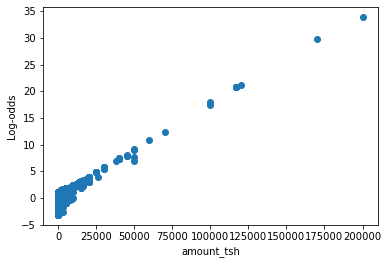

In [43]:
#Grabs probabilities and calculates log odds
pred = logreg.predict_proba(X_train)[:, 0]
log_odds = np.log(pred / (1 - pred))
#Plots log odds versus continuous variable to check for linearity
plt.scatter(x = X_train['amount_tsh'].values, y = log_odds)
plt.xlabel("amount_tsh")
plt.ylabel("Log-odds")
plt.show()

While the precision for the logistic regression model is worse, coming in at .75 for both the training and validation sets, this model is less complex and easier to implement than the first one and doesn't have any issues with overfitting or violating the assumptions of logistic regression. Therefore, it's a more viable and useable model for the NGO to potentially implement. Finally, while this model would be more complex, we were interested in running a Random Forest Classifier to see if we could get a sizeable increase in precision based on these four most important features to balance the first model and the second model in a way.

#### Random Forest Classifier

In [44]:
#Builds pipeline for random forest
ensemble = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(random_state = 42))
])

#Fits the model
ensemble.fit(X_train, y_train)
#Prints out precision for training and validation
y_pred = ensemble.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(ensemble, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score:0.7629366710255931
Validation Score:0.6688198285364692


This is only a slight increase in precision for the training score compared to the first model, as well as a drop in the validation score indicating potential overfitting. In an effort to potentially increase the performance of this model we tuned its parameters using a gridsearch.

In [46]:
#To avoid a long runtime the code is included but hashed out
"""
#Creates parameters to test
params = {
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__n_estimators': [100, 300, 500],
    'rfc__min_samples_split': [2, 5, 10]
}

#Fits gridsearch on model and prints out the best parameters
search = GridSearchCV(ensemble, param_grid = params, scoring = 'precision')
search.fit(X_train, y_train)
search.best_params_
""";

In [47]:
ensemble_tuned = Pipeline(steps=[
    ('trans', trans),
    ('rfc', RandomForestClassifier(criterion = 'entropy', min_samples_split = 5, 
                                   n_estimators = 300, random_state = 42))
])

#Fits and prints precision for tuned model
ensemble_tuned.fit(X_train, y_train)
y_pred = ensemble_tuned.predict(X_train)
print("Training Score:" + str(precision_score(y_train, y_pred)))
scores = np.mean(cross_val_score(ensemble_tuned, X_train, y_train, cv=5))
print("Validation Score:" + str(scores))

Training Score:0.7627276973376926
Validation Score:0.6689818977305354


Despite tuning the model, the performance is still only marginally better than the logistic regression model, as well as being more computationally stressful and performing worse on the validation scores. As a result, the final model we decided to go with was the logistic regression model with four features.

## Evaluation
---
To reiterate from earlier, we've been using precision as our metric as we want to avoid false positives, in this case being wells that we identify as needing attention when they are actually functional, as this would waste resources for the NGO. As a result, the logistic regression having a precision of .75 was the model we went with. While this is less than the precision of the original decision tree, this model is less computationally strenuous and therefore comparatively easier for the NGO to implement. Similarly, the model does not seem to be overfitting as the scores for both precision and accuracy of the model are close for both the training and validation sets. The assumptions for the logistic regression model are also met, meaning it could be viable to use.

In [49]:
print("Training Accuracy:" + str(logreg.score(X_train, y_train)))
scores = np.mean(cross_val_score(logreg, X_train, y_train, cv=5))
print("Validation Accuracy:" + str(scores))

Training Accuracy:0.643791530642958
Validation Accuracy:0.6445323536836469


While the logistic regression model is worse than the first decision tree model, it outperforms the baseline model which had an accuraccy of 54% and a precision of 0, indicating it's still worthwhile to use. Furthermore, it still performs well on the test set, with a precision of .73 and accuraccy of .64, both similar to the training set.

In [54]:
#Generates precision score for test set
test_pred = logreg.predict(X_test)
print("Test Score:" + str(precision_score(y_test, test_pred)))
print("Tets Accuracy:" + str(logreg.score(X_test, y_test)))

Test Score:0.737384140061792
Tets Accuracy:0.642703340973814


Therefore, the logistic regression model is the one we would put forward as out official model for the NGO. While the precision could be improved upon to make it a more reliable model, it still operates better than the baseline and meets assumptions while not seeming to overfit, thereby making it applicable to actual data the NGO would be interested in. As a result, through using this model the NGO could help identify and hone in on wells in need of repair or replacement and be able to better allocate their resources without wasting time checking up on functional wells.

## Conclusions
---
Overall, we would recommend the NGO consider using this model to help them predict which wells to focus their resources on. We would also recommend that if they have any interest in lobbying for better well construction in the future, they focus in on the total static head of the well, the installer, extraction type, and if the well has a government permit, as these were the most important features in predicting well failure. One drawback of this model is that it's built using amoun_tsh, which is one of the columns with unclear 0s representing possible nulls. Therefore to improve the model we could get more accurrate data for this column to see how it impacts the model. Furthermore this data is outdated and contains wells that date all the way back to 2003. Between then and now there could have been changes in the way wells are constructed or maintained that would impact our predictions, but we lack the data needed to see this, so that would be another future improvement we could work on.